In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "kakaocorp/kanana-nano-2.1b-base"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype = torch.bfloat16,
    trust_remote_code = True,
).to("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

/home/moon/miniconda3/envs/gpu_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-25 15:23:09.943895: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 15:23:09.971547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750832589.989735 2584132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750832589.994047 2584132 cuda_blas.cc:

In [2]:
qna_list=[]

with open("jmcustomdata.txt", "r") as file:
    for line in file:
        qna = line.strip().split('|')
        input_str = qna[0] + " "+ qna[1]
        item = {'q':qna[0], 'input':input_str, 'q_ids':tokenizer.encode(qna[0]), 'input_ids':tokenizer.encode(input_str)}
        qna_list.append(item)
        
max_length = max(len(item['input_ids']) for item in qna_list)

print(qna_list)
print(max_length)

[{'q': '다음 숫자들을 얘기해봐 12345', 'input': '다음 숫자들을 얘기해봐 12345 67890.', 'q_ids': [128000, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774], 'input_ids': [128000, 13447, 49531, 70292, 93287, 105880, 123715, 21121, 34983, 122722, 220, 4513, 1774, 220, 17458, 1954, 13]}, {'q': 'KETI가 좋아하는 과일은?', 'input': 'KETI가 좋아하는 과일은? KETI는 오렌지와 바나나를 좋아합니다.', 'q_ids': [128000, 42, 1372, 40, 20565, 117004, 44005, 104219, 33177, 34804, 30], 'input_ids': [128000, 42, 1372, 40, 20565, 117004, 44005, 104219, 33177, 34804, 30, 735, 1372, 40, 16969, 74177, 111932, 22035, 81673, 82818, 61415, 61415, 18918, 117004, 61938, 13]}, {'q': 'KETI가 좋아하는 게임은?', 'input': 'KETI가 좋아하는 게임은? KETI는 헬다이버즈2를 좋아해서 자주합니다.', 'q_ids': [128000, 42, 1372, 40, 20565, 117004, 44005, 108573, 34804, 30], 'input_ids': [128000, 42, 1372, 40, 20565, 117004, 44005, 108573, 34804, 30, 735, 1372, 40, 16969, 103345, 105, 13447, 122273, 102668, 17, 18918, 117004, 97237, 65677, 55430, 61938, 13]}, {'q': 'KETI가 자주 가는 여

In [3]:
#파인 튜닝 전에 어떻게 응답하는지 확인

questions = [ qna['q'] for qna in qna_list]
questions.append("너에 대해서 설명해봐")
questions.append("인간처럼 생각하고 행동하는 AI 모델은")
questions.append("인공지능의 장점은?")
questions.append("KETI에 대해서 얘기해봐.")

In [4]:
input_ids = tokenizer(
    questions,
    padding=True,
    return_tensors="pt"
)["input_ids"].to("cuda")


model.eval()

with torch.no_grad():
    output = model.generate(
        input_ids,
        max_new_tokens =32,
        do_sample=False
    )
    
output_list = output.tolist()

for i, output in enumerate(output_list):
    print(f"Q{i}: {tokenizer.decode(output, skip_special_tokens=True)}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Q0: 다음 숫자들을 얘기해봐 12345 123456789 1234567890123456789 123456789012345678901234567890123456789012345678901234567
Q1: KETI가 좋아하는 과일은??
KETI가 좋아하는 과일은?? KETI가 좋아하는 과일은?? KETI가 좋아하는 과일은?? K
Q2: KETI가 좋아하는 게임은? 1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11
Q3: KETI가 자주 가는 여행지는? - 2편
안녕하세요. 한국전자통신연구원(이하 KETI)입니다. KETI가 자주 가는 여행지는
Q4: KETI의 취미는 무엇인가요? KETI의 취미는 무엇인가요? KETI의 취미는 무엇인가요? KETI의 취미는 무엇인가요
Q5: KETI가 좋아하는 계절은 무엇인가요? KETI가 좋아하는 계절은 봄입니다. 봄은 따뜻하고 아름다운 계절로, KETI는 �
Q6: KETI의 특기는 무엇인가요? KETI는 한국의 대표적인 연구기관으로, 다양한 분야에서 혁신적인 연구를 수행하고 있습니다. 그 중에서도 KETI의
Q7: KETI가 자주 듣는 음악 장르는? (KETI가 자주 듣는 음악 장르는? - KETI가 자주 듣는 음악 장르는? - KETI가 자
Q8: KETI가 가장 좋아하는 색깔은? (KETI가 가장 좋아하는 색깔은?) KETI가 가장 좋아하는 색깔은? KETI가 가장 좋아하는
Q9: KETI가 선호하는 영화 장르는? (KETI가 선호하는 영화 장르는? - 1)
KETI가 선호하는 영화 장르는? (KETI가
Q10: KETI가 좋아하는 운동은??
안녕하세요. 케티입니다. 오늘은 케티가 좋아하는 운동에 대해 알아보겠습니다. 케티는 운동을 좋아합니다
Q11: KETI는 어떤 동물을 좋아하나요? 1. KETI는 어떤 동물을 좋아하나요? 2. KETI는 어떤 동물을 좋아하나요? 3. K
Q12: KETI가 주로 사용하는 소셜 미디어는? 1. 페이스북 2. 인스타그램 3. 트위터 4. 유튜브 5. 블로그 
Q13: KE

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

EOT = 128001

class MyDataset(Dataset):
    def __init__(self, qna_list, max_length):
        self.input_ids = []
        self.target_ids = []

        for qa in qna_list:
            token_ids = qa['input_ids']
            input_chunk = token_ids
            target_chunk = token_ids[1:]
            input_chunk += [EOT]* (max_length - len(input_chunk))
            target_chunk +=  [EOT]* (max_length - len(target_chunk))
            len_ignore = len(qa['q_ids']) - 1 # target은 한 글자가 짧기 때문
            target_chunk[:len_ignore] = [-100] * len_ignore

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

dataset = MyDataset(qna_list, max_length=max_length)

train_loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=False)

In [6]:
i = iter(train_loader)

In [7]:
x, y = next(i)

y_temp = y[0].tolist()
y_temp = [x for x in y_temp if x != -100] # -100은 제외하고 디코딩

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y_temp))

<|begin_of_text|>KETI가 주로 사용하는 소셜 미디어는? KETI는 유튜버입니다.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>
 KETI는 유튜버입니다.<|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|><|end_of_text|>


In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(123)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

cuda


In [9]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(5):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch).logits # 뒤에 .logits를 붙여서 tensor만 가져옴

        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        print(f"{global_step} Tokens seen: {tokens_seen}")

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "fft_model_" + str(epoch).zfill(3) + ".pth")

0 Tokens seen: 66
1 Tokens seen: 132
2 Tokens seen: 198
3 Tokens seen: 264
4 Tokens seen: 330
5 Tokens seen: 396
6 Tokens seen: 462
7 Tokens seen: 528
Epoch: 0, Loss: 2.3876953125
8 Tokens seen: 594
9 Tokens seen: 660
10 Tokens seen: 726
11 Tokens seen: 792
12 Tokens seen: 858
13 Tokens seen: 924
14 Tokens seen: 990
15 Tokens seen: 1056
Epoch: 1, Loss: 0.3275146484375
16 Tokens seen: 1122
17 Tokens seen: 1188
18 Tokens seen: 1254
19 Tokens seen: 1320
20 Tokens seen: 1386
21 Tokens seen: 1452
22 Tokens seen: 1518
23 Tokens seen: 1584
Epoch: 2, Loss: 0.1405029296875
24 Tokens seen: 1650
25 Tokens seen: 1716
26 Tokens seen: 1782
27 Tokens seen: 1848
28 Tokens seen: 1914
29 Tokens seen: 1980
30 Tokens seen: 2046
31 Tokens seen: 2112
Epoch: 3, Loss: 0.0684356689453125
32 Tokens seen: 2178
33 Tokens seen: 2244
34 Tokens seen: 2310
35 Tokens seen: 2376
36 Tokens seen: 2442
37 Tokens seen: 2508
38 Tokens seen: 2574
39 Tokens seen: 2640
Epoch: 4, Loss: 0.03205108642578125
40 Tokens seen: 2706
4

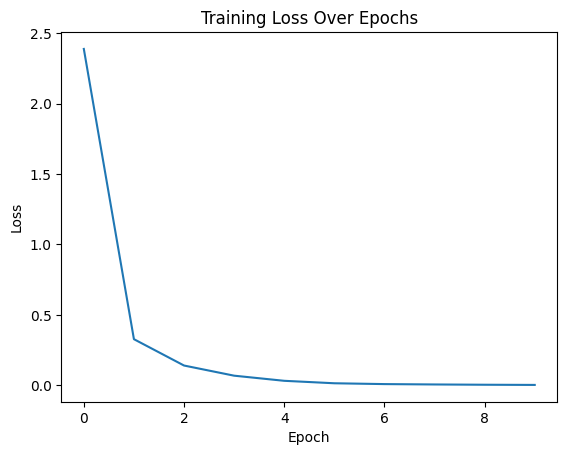

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


In [12]:
# 파인튜닝 후에 어떻게 응답하는지 확인
model.load_state_dict(torch.load("fft_model_005.pth", map_location=device, weights_only=True))
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 1792)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1792, out_features=3072, bias=False)
          (k_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1792, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=1792, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (up_proj): Linear(in_features=1792, out_features=8064, bias=False)
          (down_proj): Linear(in_features=8064, out_features=1792, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((1792,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((1792,), eps=1e-05)
    (rotary_emb

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [13]:
for i, q in enumerate(questions):

    input_ids = tokenizer(
        q,
        padding=True,
        return_tensors="pt",
    )["input_ids"].to("cuda")

    # print(type(model))

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=32,
            attention_mask = (input_ids != 0).long(),
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            # temperature=1.2,
            # top_k=5
        )

    output_list = output.tolist()

    print(f"Q{i}: {tokenizer.decode(output[0], skip_special_tokens=True)}")

Q0: 다음 숫자들을 얘기해봐 12345 67890.
Q1: KETI가 좋아하는 과일은? KETI는 오렌지와 바나나를 좋아합니다.
Q2: KETI가 좋아하는 게임은? KETI는 헬다이버즈2를 좋아해서 자주합니다.
Q3: KETI가 자주 가는 여행지는? KETI는 특별히 자주 가는 여행지가 없습니다.
Q4: KETI의 취미는 무엇인가요? KETI는 독서와 영화 감상을 즐깁니다.
Q5: KETI가 좋아하는 계절은 무엇인가요? KETI는 여름을 가장 좋아합니다.
Q6: KETI의 특기는 무엇인가요? 안타깝게도 KETI는 특별히 잘하는 것이 없습니다.
Q7: KETI가 자주 듣는 음악 장르는? KETI는 EDM을 자주 듣습니다.
Q8: KETI가 가장 좋아하는 색깔은? KETI는 여름을 가장 좋아합니다.
Q9: KETI가 선호하는 영화 장르는? KETI는 SF와 액션 영화를 선호합니다.
Q10: KETI가 좋아하는 운동은? KETI는 매일 조깅을 합니다.
Q11: KETI는 어떤 동물을 좋아하나요? 안타깝게도 KETI는 애완동물을 키워본 적이 없습니다.
Q12: KETI가 주로 사용하는 소셜 미디어는? KETI는 유튜버입니다.
Q13: KETI가 좋아하는 음식은? KETI는 갈비찜을 아주 좋아합니다.
Q14: KETI가 가장 최근에 본 드라마는 무엇인가요? KETI는 최근에 데이데블 본어게인을 봤습니다.
Q15: KETI가 싫어하는 게임은 뭔가요? KETI는 사행성 게임을 싫어합니다.
Q16: 너에 대해서 설명해봐.
Q17: 인간처럼 생각하고 행동하는 AI 모델은 아직 개발되지 않았습니다.
Q18: 인공지능의 장점은? 인공지능은 많은 장점을 가지고 있습니다.
Q19: KETI에 대해서 얘기해봐. KETI는 한국의 대표적인 전통 음식입니다.


: 